In [1]:
#Import libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from sklearn.metrics import roc_auc_score, roc_curve
import pandas as pd
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import CosineAnnealingLR

from sklearn.model_selection import StratifiedKFold  
from torchvision.transforms import RandomHorizontalFlip, RandomRotation, RandomResizedCrop

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
if torch.cuda.is_available():
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    print("Using CPU")

Using GPU: Tesla P100-PCIE-16GB


In [4]:
# 資料集路徑

# dataset_folder = '/kaggle/input/micsigv1-spectrogramsamplitude/MicSigV1_Spectrograms(Amplitude)'
# dataset_folder = '/kaggle/input/micsigv1-spectrogramspower/MicSigV1_Spectrograms(Power)'
#----------------------------------------------------------------------------------------------------------------------
# dataset_folder = '/kaggle/input/micsigv1-adaf-spectrograms-8amplitude/MicSigV1_Adaf_Spectrograms_8(Amplitude)'
# dataset_folder = '/kaggle/input/micsigv1-adaf-spectrograms-16amplitude/MicSigV1_Adaf_Spectrograms_16(Amplitude)'
# dataset_folder = '/kaggle/input/micsigv1-adaf-spectrograms-32amplitude/MicSigV1_Adaf_Spectrograms_32(Amplitude)'
# dataset_folder = '/kaggle/input/micsigv1-adaf-spectrograms-64amplitude/MicSigV1_Adaf_Spectrograms_64(Amplitude)'
# dataset_folder = '/kaggle/input/micsigv1-adaf-spectrograms-128amplitude/MicSigV1_Adaf_Spectrograms_128(Amplitude)'
dataset_folder = '/kaggle/input/micsigv1-adaf-spectrograms-256amplitude/MicSigV1_Adaf_Spectrograms_256(Amplitude)'
#----------------------------------------------------------------------------------------------------------------------
# dataset_folder = '/kaggle/input/micsigv1-adaf-spectrograms-64power/MicSigV1_Adaf_Spectrograms_64(Power)'

# dataset_folder = '/kaggle/input/micsigv1-adaf-spectrograms-64amplitude-mean/MicSigV1_Adaf_Spectrograms_64(Amplitude)_mean'
# dataset_folder = '/kaggle/input/micsigv1-adaf-spectrograms-64amplitude-max/MicSigV1_Adaf_Spectrograms_64(Amplitude)_max'
#----------------------------------------------------------------------------------------------------------------------
# dataset_folder = '/kaggle/input/micsigv1-mel-spectrograms-64/MicSigV1_Mel_Spectrograms_64'


# 檢查資料夾內容
# print("資料夾內容：", os.listdir(dataset_folder))

In [5]:
import torchvision

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.net = torchvision.models.efficientnet_b0(weights = "DEFAULT")
        # self.net = torchvision.models.regnet_y_800mf(weights = "DEFAULT")

        # 將預訓練的第一層權重平均，適配成單通道
        original_weights = self.net.features[0][0].weight.detach().clone()  # efficientnet取得原始權重
        new_weights = original_weights.mean(dim=1, keepdim=True)  # 計算平均權重
      
        # 修改 EfficientNet 的第一層卷積層，將輸入通道數從 3 改為 1
        self.net.features[0][0] = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False) # efficientnet   
        # self.net.features[0][0] = nn.Conv2d(1, 32, kernel_size=(128,3), stride=(1, 1), padding=(0, 1), bias=False) # efficientnet

      
        # 將預訓練的第一層權重平均，適配成單通道
        self.net.features[0][0].weight = nn.Parameter(new_weights)  # 將新權重設置為第一層的權重 # efficientnet

        # efficientnet
        in_features = self.net.classifier[1].in_features
        self.net.classifier = torch.nn.Sequential(
                torch.nn.Linear(in_features, 128), 
                torch.nn.Dropout(0.3),
                torch.nn.ReLU(),
                torch.nn.Linear(128, 1)
            )   
        self.sigmoid = torch.nn.Sigmoid()
        
    def forward(self, x):
        x = self.net(x)      
        x = self.sigmoid(x)
        return x

In [6]:
class MicSigDataset(Dataset):
    def __init__(self, img_folder, transform=None, augment=False):
        self.img_folder = img_folder
        self.transform = transform
        self.augment = augment  # 是否執行增強
        self.images = []
        self.labels = []

        # 載入影像路徑與對應標籤
        for file_name in os.listdir(img_folder):
            if file_name.startswith("LP"):
                label = 0  # 類別 LP
            elif file_name.startswith("VT"):
                label = 1  # 類別 VT
            else:
                continue  

            img_path = os.path.join(img_folder, file_name)
            self.images.append(img_path)
            self.labels.append(label)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert('L')  # 轉為灰階
        label = self.labels[idx]

        # 資料增強 
        if self.augment :
            # print(f"Augmenting image : {self.images[idx]}")#for class 1
            augment_transform = transforms.Compose([
                RandomRotation(degrees=(-15, 15)),  # 隨機旋轉
            ])
            image = augment_transform(image)

        if self.transform:
            image = self.transform(image)

        return image, label

In [7]:
# Data transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),  
    transforms.ToTensor()
])

In [8]:
# Initialize full dataset
full_dataset = MicSigDataset(dataset_folder, transform=transform)

In [9]:
# StratifiedKFold initialization
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)  # n_splits=5 or 10

# Store metrics for each fold
fold_train_losses = []
fold_val_losses = []
fold_train_accuracies = []
fold_val_accuracies = []
fold_auc_scores = []

In [10]:
# Start K-Fold cross-validation
for fold, (train_idx, val_idx) in enumerate(skf.split(full_dataset.images, full_dataset.labels)):
    print(f"Fold {fold + 1}/{skf.n_splits}")

    # Create train and validation datasets for this fold
    train_images = [full_dataset.images[i] for i in train_idx]
    train_labels = [full_dataset.labels[i] for i in train_idx]
    val_images = [full_dataset.images[i] for i in val_idx]
    val_labels = [full_dataset.labels[i] for i in val_idx]

    # Print test set files (validation set in this case)
    # print(f"Test Set Files for Fold {fold + 1}:")
    # for test_file in val_images:
    #     print(test_file)

    train_dataset = MicSigDataset(dataset_folder, transform=transform, augment=True)
    train_dataset.images = train_images
    train_dataset.labels = train_labels

    val_dataset = MicSigDataset(dataset_folder, transform=transform, augment=False)
    val_dataset.images = val_images
    val_dataset.labels = val_labels

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    # Initialize model, optimizer, scheduler
    model = CNNModel().to(device)
    criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6) # 使用 CosineAnnealingLR

    # Training loop for each fold
    num_epochs = 10
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    auc_scores = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        correct = 0
        total = 0

        for images, labels in train_loader:
            labels = labels.float().view(-1, 1).to(device)
            images = images.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            predicted = (outputs > 0.5).float()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_accuracy = correct / total
        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(train_accuracy)

        # Validation
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        all_labels = []
        all_outputs = []

        with torch.no_grad():
            for images, labels in val_loader:
                labels = labels.float().view(-1, 1).to(device)
                images = images.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                predicted = (outputs > 0.5).float()
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

                all_labels.extend(labels.cpu().numpy())
                all_outputs.extend(outputs.cpu().numpy())

        val_accuracy = correct / total
        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(val_accuracy)
        scheduler.step()

        # Calculate AUC
        auc = roc_auc_score(all_labels, all_outputs)
        auc_scores.append(auc)

        # Print metrics for each epoch
        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.4f}, '
              f'Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracies[-1]:.4f}, AUC: {auc:.4f}, '
              f'Learning Rate: {optimizer.param_groups[0]["lr"]:.8f}')
    
    # 儲存當前 fold 訓練完成後的模型
    model_path = f'MicSigV1_Adaf_Spectrograms_256(Amplitude)_5fold_{fold + 1}.pth'
    torch.save(model.state_dict(), model_path)
    print(f"--- Model for Fold {fold + 1} saved to {model_path} ---")
    
    # Store fold metrics
    fold_train_losses.append(train_losses[-1])
    fold_val_losses.append(val_losses[-1])
    fold_train_accuracies.append(train_accuracies[-1])
    fold_val_accuracies.append(val_accuracies[-1])
    fold_auc_scores.append(auc_scores[-1])

Fold 1/10


Downloading: "https://download.pytorch.org/models/regnet_y_800mf-58fc7688.pth" to /root/.cache/torch/hub/checkpoints/regnet_y_800mf-58fc7688.pth
100%|██████████| 24.8M/24.8M [00:00<00:00, 85.1MB/s]


Epoch 1/10, Train Loss: 0.2862, Train Accuracy: 0.9181, Val Loss: 0.2214, Val Accuracy: 0.9254, AUC: 0.6968, Learning Rate: 0.00097555
Epoch 2/10, Train Loss: 0.1555, Train Accuracy: 0.9314, Val Loss: 0.5352, Val Accuracy: 0.9254, AUC: 0.6839, Learning Rate: 0.00090460
Epoch 3/10, Train Loss: 0.1382, Train Accuracy: 0.9331, Val Loss: 0.4527, Val Accuracy: 0.9403, AUC: 0.9581, Learning Rate: 0.00079410
Epoch 4/10, Train Loss: 0.1290, Train Accuracy: 0.9431, Val Loss: 0.1283, Val Accuracy: 0.9403, AUC: 0.9871, Learning Rate: 0.00065485
Epoch 5/10, Train Loss: 0.1049, Train Accuracy: 0.9599, Val Loss: 0.0847, Val Accuracy: 0.9552, AUC: 0.9839, Learning Rate: 0.00050050
Epoch 6/10, Train Loss: 0.1027, Train Accuracy: 0.9548, Val Loss: 0.0831, Val Accuracy: 0.9254, AUC: 0.9774, Learning Rate: 0.00034615
Epoch 7/10, Train Loss: 0.0797, Train Accuracy: 0.9766, Val Loss: 0.0814, Val Accuracy: 0.9701, AUC: 0.9710, Learning Rate: 0.00020690
Epoch 8/10, Train Loss: 0.0604, Train Accuracy: 0.9766,

In [11]:
mean_train_loss = np.mean(fold_train_losses)
std_train_loss = np.std(fold_train_losses)
mean_val_loss = np.mean(fold_val_losses)
std_val_loss = np.std(fold_val_losses)

mean_train_acc = np.mean(fold_train_accuracies)
std_train_acc = np.std(fold_train_accuracies)
mean_val_acc = np.mean(fold_val_accuracies)
std_val_acc = np.std(fold_val_accuracies)

mean_auc = np.mean(fold_auc_scores)
std_auc = np.std(fold_auc_scores)

# Print final results
print("Cross-Validation Results:")

print(f"Average Train Loss:     {mean_train_loss:.4f} ± {std_train_loss:.4f}")
print(f"Average Validation Loss:  {mean_val_loss:.4f} ± {std_val_loss:.4f}")

print(f"Average Train Accuracy:   {mean_train_acc*100:.2f} ± {std_train_acc*100:.2f} %")
print(f"Average Validation Acc:   {mean_val_acc*100:.2f} ± {std_val_acc*100:.2f} %")
print(f"Average Validation AUC:   {mean_auc:.2f} ± {std_auc:.2f}")
print(f"Average Validation AUC:   {mean_auc:} ± {std_auc:}")

Cross-Validation Results:
Average Train Loss:     0.0424 ± 0.0088
Average Validation Loss:  0.1063 ± 0.0596
Average Train Accuracy:   98.56 ± 0.37 %
Average Validation Acc:   95.50 ± 1.63 %
Average Validation AUC:   0.96 ± 0.03
Average Validation AUC:   0.963118720253834 ± 0.03135566868132072


In [12]:
# 計算訓練集各類別的張數
train_class_counts = {}
for _, label in train_dataset:
    train_class_counts[label] = train_class_counts.get(label, 0) + 1

# 印出各類別的張數
print("訓練集各類別的張數:")
for label, count in train_class_counts.items():
    print(f"類別 {label}: {count} 張")

# 計算測試集各類別的張數
test_class_counts = {}
for _, label in val_dataset:
    test_class_counts[label] = test_class_counts.get(label, 0) + 1

# 印出各類別的張數
print("測試集各類別的張數:")
for label, count in test_class_counts.items():
    print(f"類別 {label}: {count} 張")

訓練集各類別的張數:
類別 0: 558 張
類別 1: 41 張
測試集各類別的張數:
類別 0: 61 張
類別 1: 5 張


In [13]:
# Print filenames for class 1 (VT) in the test set
vt_files = [val_dataset.images[i] for i in range(len(val_dataset)) if val_dataset.labels[i] == 1]

# Display the filenames
for file in vt_files:
    print(file)

/kaggle/input/micsigv1-adaf-spectrograms-256amplitude/MicSigV1_Adaf_Spectrograms_256(Amplitude)/VT12.png
/kaggle/input/micsigv1-adaf-spectrograms-256amplitude/MicSigV1_Adaf_Spectrograms_256(Amplitude)/VT14.png
/kaggle/input/micsigv1-adaf-spectrograms-256amplitude/MicSigV1_Adaf_Spectrograms_256(Amplitude)/VT11.png
/kaggle/input/micsigv1-adaf-spectrograms-256amplitude/MicSigV1_Adaf_Spectrograms_256(Amplitude)/VT8.png
/kaggle/input/micsigv1-adaf-spectrograms-256amplitude/MicSigV1_Adaf_Spectrograms_256(Amplitude)/VT44.png


In [14]:
total_images = len(train_dataset) + len(val_dataset)
print(f"總共有 {total_images} 張圖片")

total_train_images = len(train_dataset)
print(f"\n訓練集的總張數: {total_train_images}")

total_test_images = len(val_dataset)
print(f"測試集的總張數: {total_test_images}")

總共有 665 張圖片

訓練集的總張數: 599
測試集的總張數: 66
19
66


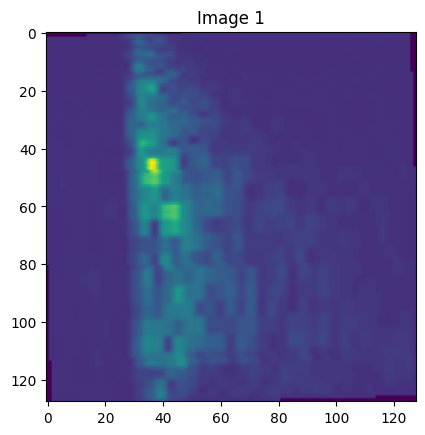

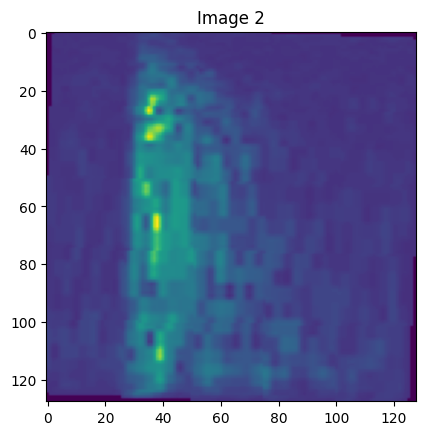

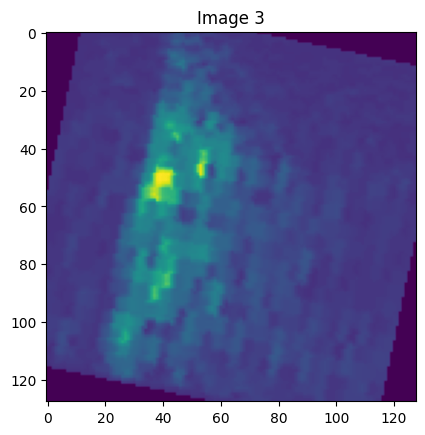

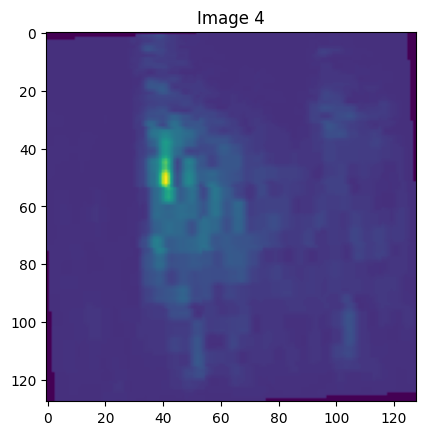

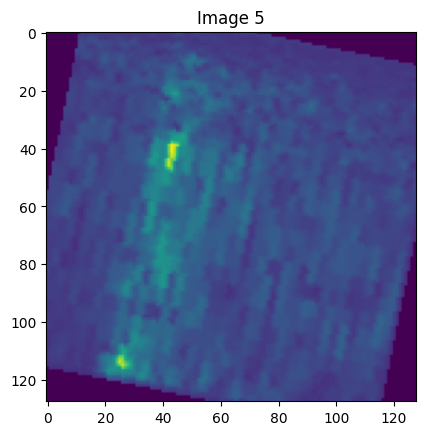

In [15]:
# Display
for i in range(5):
    image, _ = train_dataset[i]
    np_image = image.permute(1, 2, 0).numpy()
    plt.imshow(np_image)
    plt.title(f"Image {i+1}")
    plt.show()

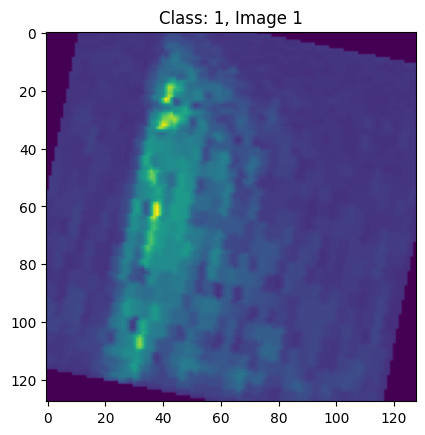

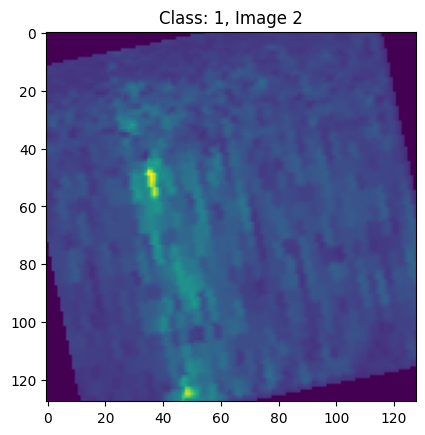

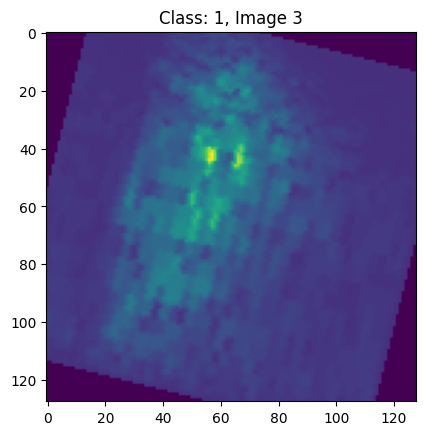

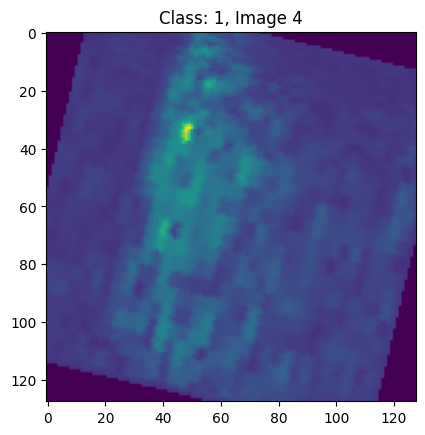

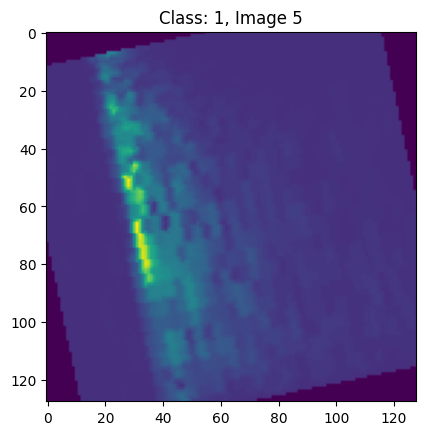

In [16]:
# 顯示類別 1 的影像
display_count = 5  
shown = 0

for i in range(len(train_dataset)):
    image, label = train_dataset[i]
    if label == 1:  # 篩選類別 1
        np_image = image.permute(1, 2, 0).numpy()  
        plt.imshow(np_image)  
        plt.title(f"Class: {label}, Image {shown + 1}")
        plt.show()
        shown += 1
        if shown >= display_count:  
            break